In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, Matern

"""
https://archive.ics.uci.edu/ml/datasets/QSAR+aquatic+toxicity

1) TPSA(Tot)
2) SAacc
3) H-050
4) MLOGP
5) RDCHI
6) GATS1p
7) nN
8) C-040
9) quantitative response, LC50 [-LOG(mol/L)]

""";

In [2]:
class dataReader(object):
    def __init__(self, seed):
        
        rng = np.random.default_rng(seed)
        data = np.loadtxt('qsar_aquatic_toxicity.csv', delimiter=';')
        rng.shuffle(data)    
        mark = int(len(data)*.8)
        training, test = data[:mark], data[mark:]
        
        X, y = training[:,:-1], training[:,-1]
        self.training_mean_x = np.mean(X, 0)
        X -= self.training_mean_x
        self.training_std_x = np.std(X, 0)
        X /= self.training_std_x
        self.training_mean_y = np.mean(y)
        y -= self.training_mean_y
        self.training_std_y = np.std(y)
        y /= self.training_std_y
        
        X_test, y_test = test[:,:-1], test[:,-1]
        X_test -= self.training_mean_x
        X_test /= self.training_std_x
        y_test -= self.training_mean_y
        y_test /= self.training_std_y
        
        self.X_train, self.y_train = X, y
        self.X_test, self.y_test = X_test, y_test

    def get_training(self):
        return self.X_train, self.y_train
    def get_test(self):
        return self.X_test, self.y_test

    def coefficient_of_determination(self, y_true, y_pred):
        """
        use wikipedia formalism
        """
        y_hat = np.mean(y_true)
        ss_res = np.sum(np.power(y_true-y_pred,2))
        ss_tot = np.sum(np.power(y_true-y_hat,2))
        return 1.-ss_res/ss_tot
    def info(self,x,y,gp):
        y_pred, y_cov = gp.predict(x, return_cov=True)
        y_std = np.sqrt(np.diag(y_cov))
        residual = y-y_pred

        # make histogram
        plt.hist(residual, bins=30)
        plt.title('residual: y-y_pred')
        plt.show()

        # make scatter plots
        useless = np.arange(len(y))
        plt.title('residual: y-y_pred')
        plt.scatter(useless, residual)
        plt.show()

        print('calculating percentages that are 1,2,3,&4 sigma away')
        for i in range(1,5):
            within = np.logical_and(y-i*y_std<=y_pred, y_pred<=y+i*y_std)
            print('sigma:',i,(np.sum(within)/len(within)).round(3))
        print('coeff. of det.',self.coefficient_of_determination(y,y_pred))

In [3]:
data = dataReader(42)

In [4]:
x, y = data.get_training()

In [5]:
x[:10].round(2), y[:10].round(2)

(array([[ 1.35,  1.74,  0.81,  0.03,  0.8 , -0.57,  0.03, -0.49],
        [ 0.15,  0.27, -0.62,  1.01,  1.5 ,  0.27, -0.75,  2.84],
        [ 0.9 ,  1.14,  0.81, -1.28,  0.39,  0.56,  0.82,  1.17],
        [-0.42, -0.92, -0.62,  0.89,  0.21, -0.93, -0.75, -0.49],
        [ 0.51,  0.6 ,  1.52, -1.52, -0.39, -0.34,  1.6 ,  1.17],
        [-0.14,  0.49,  0.81, -0.95, -1.04,  1.34, -0.75, -0.49],
        [-1.09, -0.92, -0.62, -0.39, -1.66, -1.14, -0.75, -0.49],
        [-0.65, -0.56, -0.62, -0.51, -0.42,  0.44, -0.75, -0.49],
        [-0.61, -0.22,  0.09,  0.74, -0.52, -1.68, -0.75, -0.49],
        [-0.78, -0.65, -0.62, -0.47, -0.54,  0.4 ,  0.03, -0.49]]),
 array([-0.29,  0.36, -1.38,  0.61, -0.51, -2.08, -0.82, -1.03,  0.93,
        -0.69]))

0.9999999999999999

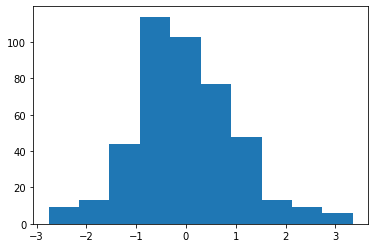

In [6]:
plt.hist(y)
np.std(y)

In [7]:
kernel = 1.**2 * Matern(length_scale=.1*np.ones(x.shape[1]),nu=2.0)\
            + 0.1**2 * WhiteKernel(noise_level=1.)

In [8]:
gpr = GaussianProcessRegressor(kernel=kernel,
                                  alpha=1e-5, 
                                  optimizer='fmin_l_bfgs_b', 
                                  n_restarts_optimizer=15, 
                                  normalize_y=False, 
                                  copy_X_train=True, 
                                  random_state=42)

In [9]:
gpr = gpr.fit(x, y)

/home/elliott/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [10]:
gpr.log_marginal_likelihood_value_

-440.91168623681625

In [11]:
gpr.kernel_

0.954**2 * Matern(length_scale=[0.458, 1.19, 1.55, 1.59, 1.09, 4.21, 0.896, 0.1], nu=2) + 0.227**2 * WhiteKernel(noise_level=2.76)

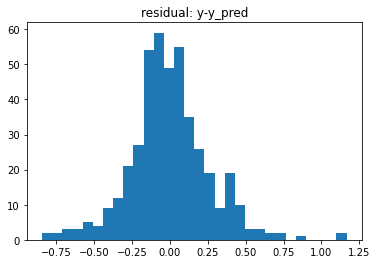

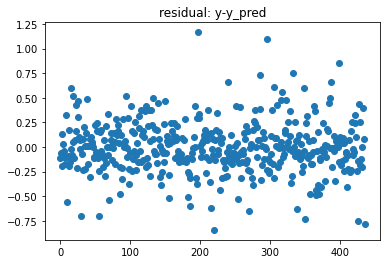

calculating percentages that are 1,2,3,&4 sigma away
sigma: 1 0.911
sigma: 2 0.993
sigma: 3 1.0
sigma: 4 1.0
coeff. of det. 0.9304125455382257


In [12]:
data.info(x,y,gpr)

In [13]:
x, y = data.get_test()

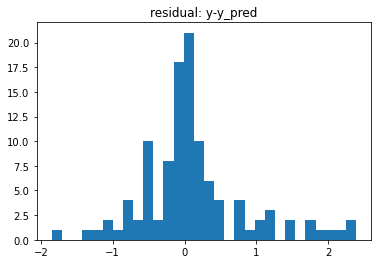

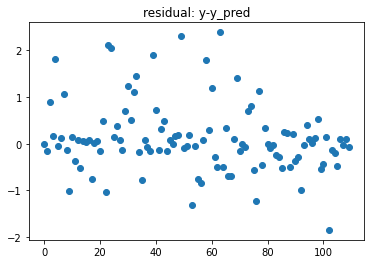

calculating percentages that are 1,2,3,&4 sigma away
sigma: 1 0.736
sigma: 2 0.918
sigma: 3 0.982
sigma: 4 0.991
coeff. of det. 0.5380484173975293


In [14]:
data.info(x,y,gpr)

In [15]:
np.save('data/sklearn_theta',gpr.kernel_.theta)